In [44]:
# Importing libraries required for the assignments
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pickle
import pprint

import sqlite3
import pandas as pd
import numpy as np
import nltk
import prettytable

import re
from wordcloud import WordCloud
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

#from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
#from sklearn.decomposition import TruncatedSVD

In [2]:
pkl_file = open('data1.pkl', 'rb')
filtered_data = pickle.load(pkl_file)
#pprint.pprint(filtered_data)
pkl_file.close()

In [3]:
# Checking columns present in data

filtered_data.columns

Index(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Sentiment',
       'CleanedText'],
      dtype='object')

In [4]:
# Time base sorting

filtered_data.sort_values('Time',inplace=True)

In [5]:
# Filtering only 100K data points for this assignments

filtered_100k=filtered_data.iloc[:100000,:]

In [6]:
filtered_100k.Time.head(20)

61682     948672000
1130      961718400
1129      962236800
26503    1067040000
26502    1067040000
54376    1067472000
35508    1067558400
35655    1067644800
35654    1067904000
10388    1067990400
82577    1068076800
26501    1068076800
81533    1068422400
55130    1068940800
98503    1069027200
75316    1069113600
36417    1069459200
44110    1070668800
22710    1071100800
74752    1071705600
Name: Time, dtype: int64

In [7]:
filtered_100k.reset_index(inplace=True)

In [8]:
label=filtered_100k.Sentiment

In [9]:
# Dropping target column
filtered_100k.drop('Sentiment',axis=1,inplace=True)

In [10]:
# Creating new label from reviews

filtered_100k['Tex_len']=filtered_100k.CleanedText.apply(lambda x:len(x.split(" ")))

In [11]:
filtered_100k.Tex_len.head()

0    28
1    17
2    36
3    10
4    15
Name: Tex_len, dtype: int64

In [12]:
filtered_100k.drop('index',axis=1,inplace=True)

In [13]:
filtered_100k.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,Tex_len
0,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...,28
1,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...,17
2,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...,36
3,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff rot gum tast good go buy gum get,10
4,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...,15


### Multinomial Naive Baye's

In [14]:
X_1, X_test, y_1, y_test = train_test_split(filtered_100k, label, test_size=0.2, random_state=50)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1,y_1, test_size=0.25, random_state=50)

In [15]:
print(X_1.shape,len(y_1))
print(X_tr.shape,len(y_tr))
print(X_test.shape,len(y_tr))

(80000, 10) 80000
(60000, 10) 60000
(20000, 10) 60000


### Bag Of Words

In [16]:
count_vector=CountVectorizer(ngram_range=(1,2))
vocab=count_vector.fit(X_tr.CleanedText)

bow_train=count_vector.transform(X_tr.CleanedText)
bow_cv=count_vector.transform(X_cv.CleanedText)
bow_test=count_vector.transform(X_test.CleanedText)

In [17]:
print(bow_train.get_shape())
print(bow_cv.get_shape())
print(bow_test.get_shape())

(60000, 837824)
(20000, 837824)
(20000, 837824)


In [37]:
# Creating summary table to store summary of models
summary_table = prettytable.PrettyTable(["Method","Model","Optimam alpha", "F-1 Score"])

# defining fait method and validation methods 
def fit_and_val(X_train,y_train,X_cv,y_cv,X_test,y_test,method,table=summary_table):
    
#    nbrs_list=np.arange(0.05,.5,0.05)
    nbrs_list=[0.0001,0.001,0.01,0.1,1,10,100]
    cv_scores=[]
# Fitting model
    scorer=make_scorer(f1_score,average='weighted')

    for Alpha in nbrs_list:
        model=MultinomialNB(alpha=Alpha)
        model.fit(X_train,y_train)
        pred = model.predict(X_cv)
#        f1_score(y_pred=pred,y_true=y_cv,pos_label='Positive')


# validating model using CV method

        
        scores=cross_val_score(estimator=model,X=X_cv,y=y_cv,cv=5,scoring=scorer)
       
        print("\nFor alpha = {:.4f}".format(Alpha))
        print ("\nmodel accuracy is {:.4f}  %".format(np.average(scores)*100))
        cv_scores.append(np.average(scores))
        
#Picking optimal value of alha having minimum error


    MSE = [1 - x for x in cv_scores]
    optimal_alpha = nbrs_list[MSE.index(min(MSE))]
    print('The optimal alpha is {:.4f} '.format(optimal_alpha))

    xi = [i for i in range(0, len(nbrs_list))]
    plt.plot(xi, MSE,marker='o', linestyle='--', color='r', label='Square')

    for xy in zip(xi, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    
    plt.xlabel('Alpha Value')
    plt.ylabel('Misclassification Error')
    plt.xticks(xi, nbrs_list)
    
    plt.show()

    print("\n\nThe misclassification error for each alpha value is : ", np.round(MSE,3))

    NB_optimal = MultinomialNB(alpha=optimal_alpha)

# fitting the model on test data
    NB_optimal.fit(X_train, y_train)

# predict the response
    pred = NB_optimal.predict(X_test)
    f1=f1_score(y_pred=pred,y_true=y_test,pos_label='Positive')
    score=f1*100
    print ("\n\nF-1 Scores on test data on optimal alpha is  {:.4f} %\n\n".format(f1*100))
    
# Adding enteries to summary table

    table.add_row([method,'MultinomialNB',optimal_alpha,score])

# evaluate accuracy

    cnf_mtrx=confusion_matrix(y_true=y_test, y_pred=pred, labels=None, sample_weight=None)
#    print(cnf_mtrx)
# Heatmap to display
    sns.heatmap(cnf_mtrx,annot=True,cmap='Blues', fmt='g')
    print (classification_report(y_cv, pred))
    return optimal_alpha,score,NB_optimal

    

In [34]:
#function to display most important features for labels 

#def show_most_informative_features(vectorizer, model, n=10):
#    feature_names = vectorizer.get_feature_names()
#    coefs_with_fns = sorted(zip(model.coef_[0], feature_names))
#    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
#    print("Positive\t\t\t\t\t\tNegative")
#    print("________________________________________________________________________________________________")
#    for (coef_1, fn_1), (coef_2, fn_2) in top:
#        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

## Applying Multinomial Naive Bayes on BOW


For alpha = 0.0001

model accuracy is 83.9619  %

For alpha = 0.0010

model accuracy is 85.7943  %

For alpha = 0.0100

model accuracy is 87.7032  %

For alpha = 0.1000

model accuracy is 87.8034  %

For alpha = 1.0000

model accuracy is 77.0763  %

For alpha = 10.0000

model accuracy is 76.8719  %

For alpha = 100.0000

model accuracy is 76.8719  %
The optimal alpha is 0.1000 


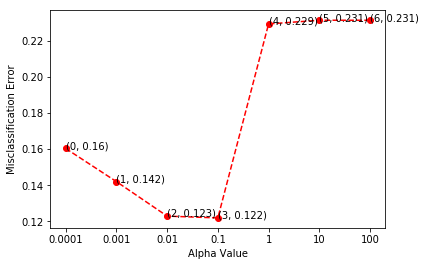



The misclassification error for each alpha value is :  [0.16  0.142 0.123 0.122 0.229 0.231 0.231]


F-1 Scores on test data on optimal alpha is  94.6541 %


             precision    recall  f1-score   support

   Negative       0.17      0.13      0.14      3175
   Positive       0.84      0.89      0.86     16825

avg / total       0.74      0.77      0.75     20000



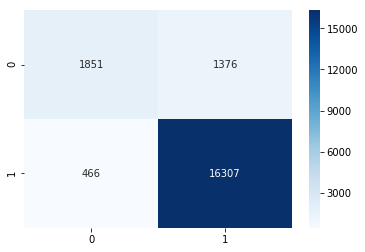

In [38]:
bow_opt_alpha,bow_tr_f1_score,Model=fit_and_val(bow_train,y_tr,bow_cv,y_cv,bow_test,y_test,"BOW")

In [52]:
w = count_vector.get_feature_names()
coef = Model.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))


#wordcloud=WordCloud(max_words=20,scale=3,background_color='white').generate(str(coeff_df.Word.tail(20)))

#plt.imshow(wordcloud)
#plt.axis('off')
#print(wordcloud)


-Top 20 positive-
Coefficient     Word
  -5.039145     like
  -5.166778     tast
  -5.307031     love
  -5.323890     good
  -5.344754   flavor
  -5.415799    great
  -5.440270      one
  -5.453532      use
  -5.484936  product
  -5.541827      tri
  -5.563480    coffe
  -5.658947      tea
  -5.724008      get
  -5.735035     make
  -5.739106     food
  -5.966698    would
  -6.020178      dog
  -6.023674      eat
  -6.038698      buy
  -6.040879     time

-Top 20 negative-
Coefficient                Word
 -17.414669         zoji direct
 -17.414669          zoji thier
 -17.414669                zola
 -17.414669         zola samzon
 -17.414669         zone moment
 -17.414669          zone sorri
 -17.414669            zone wow
 -17.414669           zoo store
 -17.414669           zoom find
 -17.414669           zoom imag
 -17.414669         zoom matter
 -17.414669         zoom within
 -17.414669   zsweet erythritol
 -17.414669  zucchini asparagus
 -17.414669       zucchini plum
 -17.4146





### TF-IDF intialization and dimension creation

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
filtered_tf_idf = tf_idf_vect.fit(X_tr.CleanedText)
print("the type of count vectorizer ",type(filtered_tf_idf))
#print("the shape of out TF-IDF vectorizer ",filtered_tf_idf.get_shape())

the type of count vectorizer  <class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [31]:

tf_idf_train=tf_idf_vect.transform(X_tr.CleanedText)
tf_idf_cv=tf_idf_vect.transform(X_cv.CleanedText)
tf_idf_test=tf_idf_vect.transform(X_test.CleanedText)

In [32]:
print(tf_idf_train.get_shape())
print(tf_idf_cv.get_shape())
print(tf_idf_test.get_shape())

(60000, 837824)
(20000, 837824)
(20000, 837824)


## Applying Naive Bayes on TF-IDF

In [53]:
# Creating summary table to store summary of models
#summary_table = prettytable.PrettyTable(["Method","Optimam alpha", "F-1 Score"])

# defining fait method and validation methods 
def fit_and_val(X_train,y_train,X_cv,y_cv,X_test,y_test,method,table=summary_table):
    
#    nbrs_list=np.arange(0.05,.5,0.05)
    nbrs_list=[0.0001,0.001,0.01,0.1,1,10,100]
    cv_scores=[]
# Fitting model
    scorer=make_scorer(f1_score,average='weighted')

    for Alpha in nbrs_list:
        model=BernoulliNB(alpha=Alpha)
        model.fit(X_train,y_train)
        pred = model.predict(X_cv)
#        f1_score(y_pred=pred,y_true=y_cv,pos_label='Positive')


# validating model using CV method


        scores=cross_val_score(estimator=model,X=X_cv,y=y_cv,cv=5,scoring=scorer)
       
        print("\nFor alpha = {:.4f}".format(Alpha))
        print ("\nmodel accuracy is {:.4f}  %".format(np.average(scores)*100))
        cv_scores.append(np.average(scores))
        
#Picking optimal value of alha having minimum error


    MSE = [1 - x for x in cv_scores]
    optimal_alpha = nbrs_list[MSE.index(min(MSE))]
    print('The optimal alpha is {:.4f} '.format(optimal_alpha))

    xi = [i for i in range(0, len(nbrs_list))]
    plt.plot(xi, MSE,marker='o', linestyle='--', color='b', label='Square')

    for xy in zip(xi, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Alpha Value')
    plt.ylabel('Misclassification Error')
    plt.xticks(xi,nbrs_list)
    plt.show()

    print("\n\nThe misclassification error for each alpha value is : ", np.round(MSE,3))

    NB_optimal = BernoulliNB(alpha=optimal_alpha)

# fitting the model on test data
    NB_optimal.fit(X_train, y_train)

# predict the response
    pred = NB_optimal.predict(X_test)
    f1=f1_score(y_pred=pred,y_true=y_test,pos_label='Positive')
    score=f1*100
    print ("\n\nF-1 Scores on test data on optimal alpha is  {:.4f} %\n\n".format(f1*100))
    
# Adding enteries to summary table

    table.add_row([method,'BernoulliNB',optimal_alpha,score])

# evaluate accuracy

    cnf_mtrx=confusion_matrix(y_true=y_test, y_pred=pred, labels=None, sample_weight=None)
#    print(cnf_mtrx)
# Heatmap to display
    sns.heatmap(cnf_mtrx,annot=True,cmap='Blues', fmt='g')
    print (classification_report(y_cv, pred))
    return optimal_alpha,score,NB_optimal

    


For alpha = 0.0001

model accuracy is 83.7248  %

For alpha = 0.0010

model accuracy is 85.5982  %

For alpha = 0.0100

model accuracy is 87.7073  %

For alpha = 0.1000

model accuracy is 82.8241  %

For alpha = 1.0000

model accuracy is 76.9076  %

For alpha = 10.0000

model accuracy is 76.8719  %

For alpha = 100.0000

model accuracy is 76.8719  %
The optimal alpha is 0.0100 


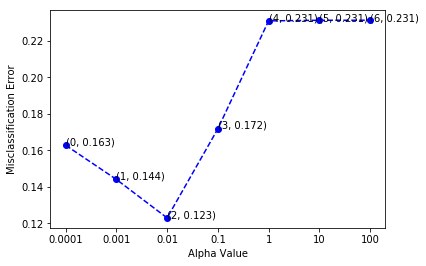



The misclassification error for each alpha value is :  [0.163 0.144 0.123 0.172 0.231 0.231 0.231]


F-1 Scores on test data on optimal alpha is  93.9311 %


             precision    recall  f1-score   support

   Negative       0.18      0.08      0.11      3175
   Positive       0.84      0.93      0.88     16825

avg / total       0.74      0.79      0.76     20000



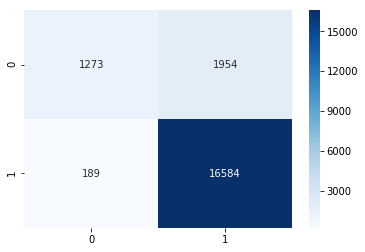

In [54]:
tf_idf_opt_alpha,tf_idf_test_f1_score,Model=fit_and_val(tf_idf_train,y_tr,tf_idf_cv,y_cv,tf_idf_test,y_test,"TF-IDF")

In [55]:
w = tf_idf_vect.get_feature_names()
coef = Model.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))



-Top 20 positive-
Coefficient     Word
  -1.146684     like
  -1.221936     tast
  -1.230764     love
  -1.296809     good
  -1.330148    great
  -1.432382   flavor
  -1.463227      one
  -1.508920      tri
  -1.537242  product
  -1.541328      use
  -1.677695      get
  -1.691223     make
  -1.903187    would
  -1.906399      buy
  -1.935091     time
  -1.960943   realli
  -1.977213   amazon
  -2.018934    price
  -2.021488     much
  -2.038170     best

-Top 20 negative-
Coefficient                Word
 -15.428881         zoji direct
 -15.428881          zoji thier
 -15.428881                zola
 -15.428881         zola samzon
 -15.428881         zone moment
 -15.428881          zone sorri
 -15.428881            zone wow
 -15.428881           zoo store
 -15.428881           zoom find
 -15.428881           zoom imag
 -15.428881         zoom matter
 -15.428881         zoom within
 -15.428881   zsweet erythritol
 -15.428881  zucchini asparagus
 -15.428881       zucchini plum
 -15.4288

In [93]:
print(summary_table)

+--------+---------------+---------------+-------------------+
| Method |     Model     | Optimam alpha |     F-1 Score     |
+--------+---------------+---------------+-------------------+
|  BOW   | MultinomialNB |      0.1      | 94.65405154399814 |
| TF-IDF |  BernoulliNB  |      0.01     | 93.93106963835632 |
+--------+---------------+---------------+-------------------+


## Conclusion:The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts.MultinomailNB performmed better on Bag of Word technique as compared to TF-IDF, and predicted some good numbers of Negative class as well